In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import pickle 
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample

%matplotlib inline

import alibi
from alibi.explainers import CounterfactualProto, Counterfactual
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
import dice_ml

from warnings import simplefilter
simplefilter('ignore')

sys.path.append('../')

from src.training.caseci import *
from src.explainers import *
from src.timelimit import *

pd.set_option('display.max_columns', 500)

import tensorflow as tf
# tf.get_logger().setLevel(40)
# tf.compat.v1.disable_v2_behavior()
tf.__version__

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


'1.15.0'

In [2]:
case = CaseCI()

In [3]:
case.train_model()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 w

In [4]:
case.save_pipe(1, 'case_mean_imp')

ROC AUC train :  0.6738824367934839 
 ROC AUC val :  0.6408452273092748 
 ROC AUC test :  0.6412330366802789 

Precision test :  0.8477747144545097
Recall test :  0.7040641099026903


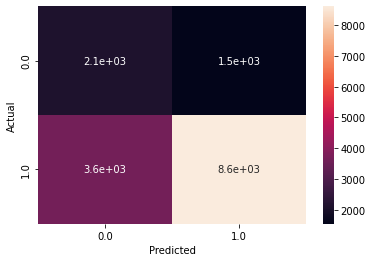

In [5]:
case.print_metrics()

## PDP

1.	Общее количество сделок, заключенных с организацией на текущий день. С ростом количества открытых сделок на одного клиента вероятность отказа снижается на 10%. Формулировка задачи: «Проверь по своим клиентам соблюдение контактной политики. Старайся оперативно реагировать на потребности клиента». Выводим, если менее 5 открытых сделок на одного клиента
F_5 (PDP-plot)
2.	Доля завершенных звонков среди всех активностей за 3 дня. С ростом доли звонков среди всех активностей вероятность отказа растет на 1%. «Старайся поддерживать очный контакт с клиентами». Выводим, если более 0.9 доля звонков.
F_12 (PDP-plot)
3.	Среднее количество уникальных продуктов, предложенных клиенту за 3 дня. С ростом количества уникальных предложенных продуктов вероятность отказа растет на 2%. «Старайся точно идентифицировать потребности клиента и не предлагать новые продукты без необходимости». Выводим, если более 4 количество уникальных предложенных продуктов.
F_24 (PDP-plot)
4.	Количество уникальных продуктов, предложенных клиентам за 3 дня. С ростом числа уникальных предложенных продуктов у клиента вероятность отказа растет на 0.9%. «Старайся не предлагать большой ряд продуктов, уточни потребность клиента». Выводим, если более 15 уникальных предложенных клиентам продуктов.
F_18 (PDP-plot)
5.	Среднее количество завершенных встреч и завершенных звонков за 3 дня. Если совершать встречи, вероятность отказа снижается на 0.4%. «Старайся поддерживать очный контакт с клиентом». Выводим, если нет встреч и есть звонки за последние 3 дня.
F_15, F_72 (PDP-plot)



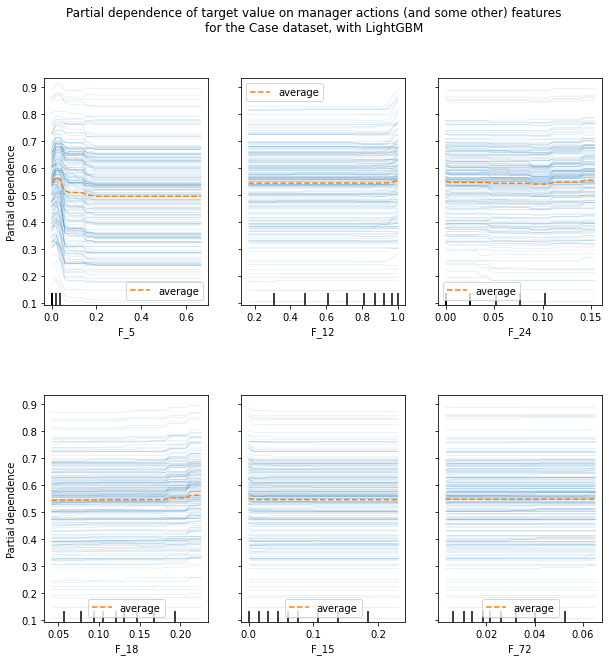

In [6]:
features = ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72'
           ]
title_fill = ['manager actions (and some other) features', 'Case', 'LightGBM']
plot_pdp_ice(case.grid_pipe_lgbm, case.X_train, features, title_fill)

## Feature importance

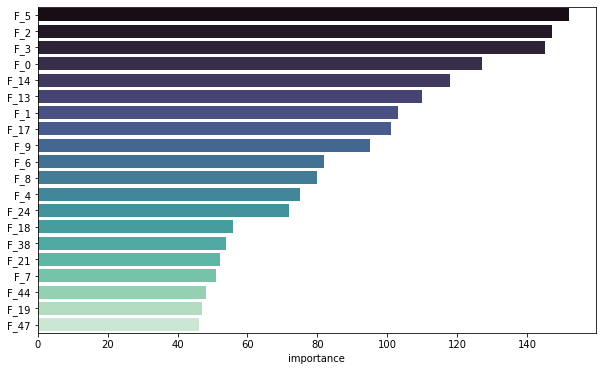

In [7]:
case.get_fimp(20)

## SHAP

In [93]:
import shap 
shap.initjs()
explainer = shap.TreeExplainer(case.grid_pipe_lgbm.best_estimator_)
shap_values = explainer.shap_values(case.X_test)

In [94]:
k = 76
shap.force_plot(explainer.expected_value[1], shap_values[1][k,:], case.X_test.iloc[k,:])

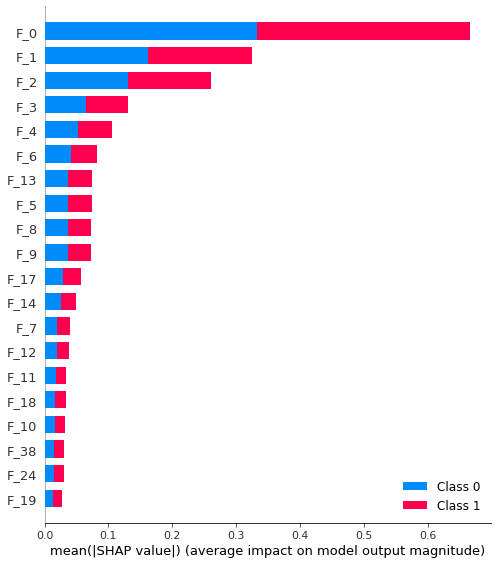

In [31]:
shap.summary_plot(shap_values, case.X_train)

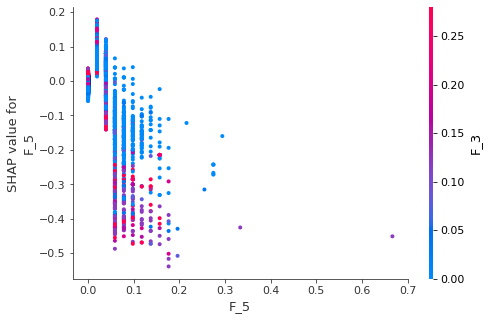

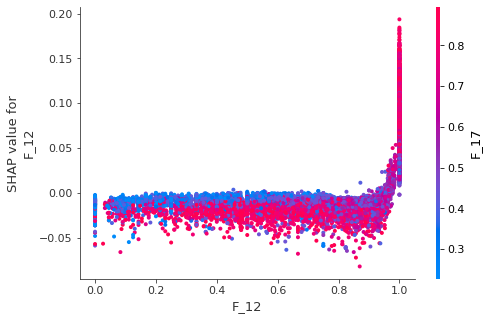

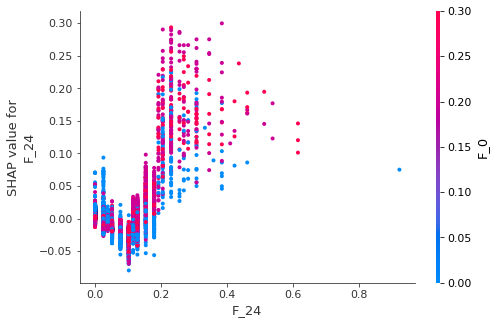

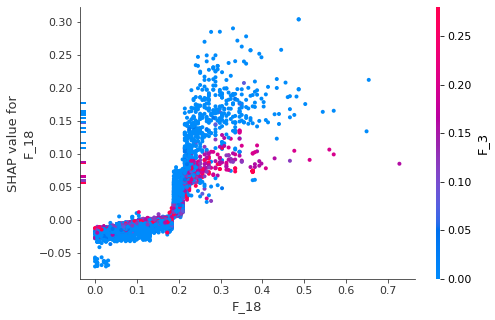

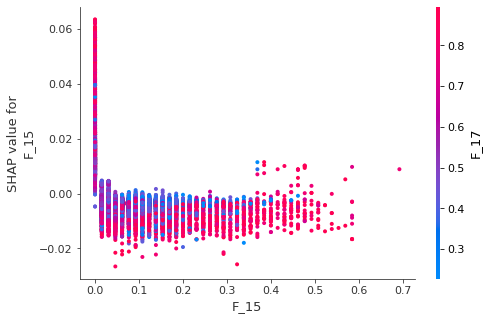

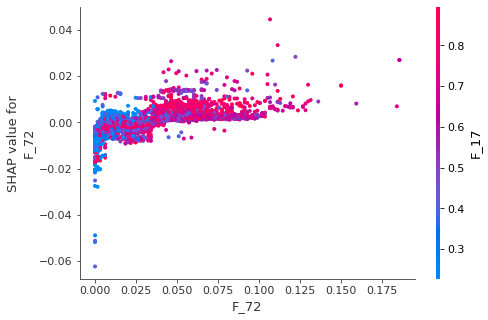

In [35]:
for name in ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72']:
    shap.dependence_plot(name, shap_values[1], case.X_test, display_features=case.X_test)

## Counterfactuals

In [17]:
not_closed_pred = (case.grid_pipe_lgbm.predict(case.X_test) == 1)
not_closed_pred = [i for i, x in enumerate(not_closed_pred) if x]
len(not_closed_pred)

10156

In [7]:
X_dice = case.X_train.copy()
X_dice['target'] = case.y_train
d = dice_ml.Data(dataframe=X_dice, 
                           continuous_features=case.names, 
                           outcome_name='target')
m = dice_ml.Model(model=case.grid_pipe_lgbm, backend='sklearn')
exp = dice_ml.Dice(d,m)

In [8]:
features_to_vary = ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72']

In [9]:
query_instances = case.X_test.iloc[[78]] #X_dice.iloc[[8]].drop(columns=['target'])
try:
    with time_limit(10):
        res = exp.generate_counterfactuals(query_instances, total_CFs=5, 
                                           desired_class="opposite", verbose=False,
                                           features_to_vary=features_to_vary
                                          )
except TimeoutException as e:
    print("Timed out!")

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


In [10]:
res.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


F_0  F_1       F_2  F_3  F_4       F_5  F_6  F_7       F_8  F_9  F_10  \
0  0.2  1.0  0.073141  0.0  1.0  0.039216  0.5  0.0  0.016529  0.0   0.0   

       F_11      F_12      F_13      F_14      F_15  F_16      F_17      F_18  \
0  0.157895  0.666667  0.088362  0.072517  0.046154   0.0  0.421007  0.094241   

   F_19      F_20      F_21      F_22  F_23      F_24  F_25      F_26  F_27  \
0  0.16  0.096774  0.132006  0.243902   0.0  0.179231   0.0  0.456667  0.75   

   F_28      F_29  F_30  F_31  F_32  F_33  F_34  F_35      F_36  F_37  \
0   0.0  0.166894   0.0   1.0  0.12   0.0   0.0   0.0  0.474836  0.25   

       F_38      F_39     F_40      F_41      F_42      F_43      F_44  \
0  0.037555  0.037728  0.47561  0.285714  0.035433  0.021829  0.039216   

       F_45      F_46      F_47      F_48      F_49  F_50  F_51   F_52  \
0  0.142809  0.228515  0.044199  0.095472  0.045099   0.0   0.5  0.125   

       F_53      F_54      F_55      F_56  F_57  F_58      F_59  F_60  F_61  \
0  0.409091  0.188119  0.333333  0.779446   1.0   0.0  0.040534   0.0   0.0   

       F_62      F_63  F_64      F_65      F_66  F_67      F_68      F_69  \
0  0.184882  0.094017   0.0  0.262238  0.090909   1.0  0.112907  0.471278   

   F_70      F_71      F_72      F_73  F_74  F_75      F_76      F_77  F_78  \
0   0.0  0.009317  0.009274  0.209163   0.0   0.0  0.017094  0.737762  0.25   

       F_79  F_80  F_81  F_82  F_83      F_84  target  
0  0.022814   0.0   0.0   0.0   0.0  0.662129       1


No counterfactuals found!


In [16]:
not_closed_pred[-10:]

[15878, 15879, 15880, 15886, 15887, 15889, 15890, 15892, 15893, 15894]

In [23]:
c = 0
cfs = {}
for row in not_closed_pred: #[c for c in not_closed_pred if c > 10698]:
    print(row)
    query_instances = case.X_test.iloc[[row]]
    try:
        with time_limit(5):
            res = exp.generate_counterfactuals(query_instances, total_CFs=5, 
                                   desired_class="opposite", verbose=False,
                                   features_to_vary=features_to_vary)
    except TimeoutException as e:
        c += 1
        print(f"""Problem for item {row}, # defect rows {c} """)
        pass
    if res.cf_examples_list[0].final_cfs_df is not None:
        print(f""" Found CF for {len(cfs)+1} rows""")
        cfs[row] = res.cf_examples_list[0].final_cfs_df.to_dict('records')

10700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10705


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


 Found CF for 1 rows
10706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10712


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10712, # defect rows 1 
10713


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10713, # defect rows 2 
10714


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10714, # defect rows 3 
10715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10716


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10716, # defect rows 4 
10717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10719


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


 Found CF for 2 rows
10720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10724


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


 Found CF for 3 rows
10725


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10725, # defect rows 5 
 Found CF for 4 rows
10727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10729


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10729, # defect rows 6 
10733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10734


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10734, # defect rows 7 
10735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10737


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10737, # defect rows 8 
10739


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10739, # defect rows 9 
10740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10743


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10743, # defect rows 10 
10744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10749


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


 Found CF for 5 rows
10750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10751


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10751, # defect rows 11 
10752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10762


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


 Found CF for 6 rows
10763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10769


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10769, # defect rows 12 
10770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10804


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10804, # defect rows 13 
10806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10810


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


 Found CF for 7 rows
10811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10814


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


 Found CF for 8 rows
10815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10822


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10822, # defect rows 14 
10823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10830


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10830, # defect rows 15 
10831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10841


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


 Found CF for 9 rows
10843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10857


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10857, # defect rows 16 
10863


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10863, # defect rows 17 
10864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10870


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10870, # defect rows 18 
10871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10875


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10875, # defect rows 19 
10876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10916


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10916, # defect rows 20 
10919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10931


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10931, # defect rows 21 
10932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10934


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


 Found CF for 10 rows
10936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10941


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


 Found CF for 11 rows
10942


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


 Found CF for 12 rows
10943


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec
10944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10945


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10945, # defect rows 22 
10946


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
10947


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10947, # defect rows 23 
10949


  0%|                                                     | 0/1 [00:39<?, ?it/s]


Problem for item 10949, # defect rows 24 
10950


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10950, # defect rows 25 
10951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10953


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10953, # defect rows 26 
10954


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


 Found CF for 13 rows
10958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10962


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10962, # defect rows 27 
10964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10981


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 10981, # defect rows 28 
10982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10990


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 10990, # defect rows 29 
10992


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
 Found CF for 14 rows
10994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
10999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11003


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11003, # defect rows 30 
11004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11005


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11005, # defect rows 31 
11007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11009


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11009, # defect rows 32 
11010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11016


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11016, # defect rows 33 
11017


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


 Found CF for 15 rows
11018


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11018, # defect rows 34 
 Found CF for 16 rows
11019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11032


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11032, # defect rows 35 
11033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11036


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11036, # defect rows 36 
11037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11041


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11041, # defect rows 37 
11042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11047


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


 Found CF for 17 rows
11048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11050


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11050, # defect rows 38 
11051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11055


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11055, # defect rows 39 
11057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11075


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11075, # defect rows 40 
11076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11078


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11078, # defect rows 41 
11079


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
 Found CF for 18 rows
11081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11082


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11082, # defect rows 42 
11083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11088


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11088, # defect rows 43 
11090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11098


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11098, # defect rows 44 
11099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11106


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11106, # defect rows 45 
11107


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11107, # defect rows 46 
11108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11110


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11110, # defect rows 47 
11111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11114


  0%|                                                     | 0/1 [00:31<?, ?it/s]


Problem for item 11114, # defect rows 48 
11118


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


 Found CF for 19 rows
11119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11120


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11120, # defect rows 49 
11121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11132


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


 Found CF for 20 rows
11133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11141


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


 Found CF for 21 rows
11144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11154


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11154, # defect rows 50 
11157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11158


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11158, # defect rows 51 
11159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11166


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11166, # defect rows 52 
11167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11168


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11168, # defect rows 53 
11170


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11170, # defect rows 54 
11171


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


 Found CF for 22 rows
11173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11184


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11184, # defect rows 55 
11186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11187


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11187, # defect rows 56 
11188


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11188, # defect rows 57 
11190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11194


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


 Found CF for 23 rows
11196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11197


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11197, # defect rows 58 
11199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11207


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


 Found CF for 24 rows
11209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11215


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11215, # defect rows 59 
11216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11239


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11239, # defect rows 60 
11240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11251


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11251, # defect rows 61 
11252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11253


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11253, # defect rows 62 
11255


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11255, # defect rows 63 
11257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11264


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11264, # defect rows 64 
11265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11271


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11271, # defect rows 65 
11272


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11272, # defect rows 66 
11273


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11273, # defect rows 67 
11277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11278


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11278, # defect rows 68 
11279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11281


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


 Found CF for 25 rows
11282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11296


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11296, # defect rows 69 
11297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11300


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11300, # defect rows 70 
11301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11310


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11310, # defect rows 71 
11311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11312


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11312, # defect rows 72 
11313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11316


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11316, # defect rows 73 
11317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11319


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11319, # defect rows 74 
11320


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11320, # defect rows 75 
11321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11325


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


 Found CF for 26 rows
11327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11329


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11329, # defect rows 76 
11331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11342


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11342, # defect rows 77 
11343


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11343, # defect rows 78 
11344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11345


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


 Found CF for 27 rows
11346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11349


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


 Found CF for 28 rows
11351


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11351, # defect rows 79 
 Found CF for 29 rows
11354


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


 Found CF for 30 rows
11356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11357


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11357, # defect rows 80 
11359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11361


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


 Found CF for 31 rows
11362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11364


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11364, # defect rows 81 
11366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11367


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11367, # defect rows 82 
11369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11378


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11378, # defect rows 83 
11379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11382


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11382, # defect rows 84 
11384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11387


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


 Found CF for 32 rows
11388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11391


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11391, # defect rows 85 
11392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11397


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11397, # defect rows 86 
11398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11399


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11399, # defect rows 87 
11402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11410


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11410, # defect rows 88 
11411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11422


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11422, # defect rows 89 
11426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11435


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11435, # defect rows 90 
11437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11442


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11442, # defect rows 91 
11443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11461


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11461, # defect rows 92 
11462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11470


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11470, # defect rows 93 
11471


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11471, # defect rows 94 
11476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11479


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11479, # defect rows 95 
11480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11482


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11482, # defect rows 96 
11484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11499


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11499, # defect rows 97 
11500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11516


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11516, # defect rows 98 
11517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11523


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11523, # defect rows 99 
11526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11543


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11543, # defect rows 100 
11544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11545


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11545, # defect rows 101 
11546


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11546, # defect rows 102 
11547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11552


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11552, # defect rows 103 
11554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11557


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


 Found CF for 33 rows
11560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11571


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11571, # defect rows 104 
11573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11580


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11580, # defect rows 105 
11581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11587


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11587, # defect rows 106 
11588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11590


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11590, # defect rows 107 
11594


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11594, # defect rows 108 
11596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11600


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11600, # defect rows 109 
11601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11605


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11605, # defect rows 110 
11606


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


 Found CF for 34 rows
11607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11615


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11615, # defect rows 111 
11616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11621


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11621, # defect rows 112 
11623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11625


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11625, # defect rows 113 
11626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11635


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11635, # defect rows 114 
11638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11643


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11643, # defect rows 115 
11644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11645


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11645, # defect rows 116 
11646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11658


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11658, # defect rows 117 
11660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11666


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11666, # defect rows 118 
11673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11682


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11682, # defect rows 119 
11686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11690


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


 Found CF for 35 rows
11693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11695


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


 Found CF for 36 rows
11698


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11698, # defect rows 120 
 Found CF for 37 rows
11699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11724


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11724, # defect rows 121 
11726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11730


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11730, # defect rows 122 
11731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11734


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11734, # defect rows 123 
11735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11742


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


 Found CF for 38 rows
11747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11749


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11749, # defect rows 124 
11751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11755


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11755, # defect rows 125 
11756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11758


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11758, # defect rows 126 
11759


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11759, # defect rows 127 
11761


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11761, # defect rows 128 
11762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11777


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11777, # defect rows 129 
11778


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11778, # defect rows 130 
11779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11788


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11788, # defect rows 131 
11789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11790


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11790, # defect rows 132 
11791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11795


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


 Found CF for 39 rows
11796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11804


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11804, # defect rows 133 
11805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11809


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11809, # defect rows 134 
11810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11815


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11815, # defect rows 135 
11816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11841


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11841, # defect rows 136 
11843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11845


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11845, # defect rows 137 
11846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11861


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11861, # defect rows 138 
11863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11865


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11865, # defect rows 139 
11866


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


 Found CF for 40 rows
11868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11874


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11874, # defect rows 140 
11875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11877


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
 Found CF for 41 rows
11879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11904


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11904, # defect rows 141 
11906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11915


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11915, # defect rows 142 
11916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11929


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11929, # defect rows 143 
11930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11933


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11933, # defect rows 144 
11934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11940


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11940, # defect rows 145 
11943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11961


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11961, # defect rows 146 
11962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11967


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11967, # defect rows 147 
11968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11969


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11969, # defect rows 148 
11970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11972


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


 Found CF for 42 rows
11974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11979


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11979, # defect rows 149 
11981


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


 Found CF for 43 rows
11984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11985


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 11985, # defect rows 150 
11987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11993


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 11993, # defect rows 151 
11994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
11995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12004


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12004, # defect rows 152 
12005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12018


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12018, # defect rows 153 
12020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12032


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12032, # defect rows 154 
12033


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


 Found CF for 44 rows
12034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12035


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12035, # defect rows 155 
12037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12039


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12039, # defect rows 156 
12040


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


 Found CF for 45 rows
12041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12043


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12043, # defect rows 157 
12044


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12044, # defect rows 158 
12045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12046


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12046, # defect rows 159 
12047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12050


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


 Found CF for 46 rows
12052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12053


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12053, # defect rows 160 
12054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12057


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12057, # defect rows 161 
12059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12085


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


 Found CF for 47 rows
12086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12090


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12090, # defect rows 162 
12091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12095


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


 Found CF for 48 rows
12096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12113


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


 Found CF for 49 rows
12114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12120


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12120, # defect rows 163 
12121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12122


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


 Found CF for 50 rows
12124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12137


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


 Found CF for 51 rows
12138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12142


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12142, # defect rows 164 
12144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12150


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12150, # defect rows 165 
12151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12158


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12158, # defect rows 166 
12162


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12162, # defect rows 167 
12163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12173


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12173, # defect rows 168 
12176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12184


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12184, # defect rows 169 
12185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12189


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12189, # defect rows 170 
12190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12191


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12191, # defect rows 171 
12192


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12192, # defect rows 172 
12193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12213


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12213, # defect rows 173 
12216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12222


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


 Found CF for 52 rows
12226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12252


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


 Found CF for 53 rows
12253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12255


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12255, # defect rows 174 
12260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12263


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12263, # defect rows 175 
12264


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12264, # defect rows 176 
12265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12276


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12276, # defect rows 177 
12278


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12278, # defect rows 178 
12279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12284


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12284, # defect rows 179 
12285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12293


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


 Found CF for 54 rows
12294


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12294, # defect rows 180 
 Found CF for 55 rows
12298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12305


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12305, # defect rows 181 
12306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12308


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


 Found CF for 56 rows
12309


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12309, # defect rows 182 
 Found CF for 57 rows
12310


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12310, # defect rows 183 
 Found CF for 58 rows
12311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12313


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12313, # defect rows 184 
12314


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12314, # defect rows 185 
12315


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12315, # defect rows 186 
12316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12317


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12317, # defect rows 187 
12318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12331


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12331, # defect rows 188 
12333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12338


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12338, # defect rows 189 
12339


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12339, # defect rows 190 
12340


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12340, # defect rows 191 
12341


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12341, # defect rows 192 
12343


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12343, # defect rows 193 
12344


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12344, # defect rows 194 
12345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12346


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12346, # defect rows 195 
12347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12350


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12350, # defect rows 196 
12351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12352


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12352, # defect rows 197 
12353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12363


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12363, # defect rows 198 
12364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12373


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12373, # defect rows 199 
12375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12391


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


 Found CF for 59 rows
12392


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12392, # defect rows 200 
 Found CF for 60 rows
12395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12401


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12401, # defect rows 201 
12403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12406


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12406, # defect rows 202 
12407


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


 Found CF for 61 rows
12408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12411


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12411, # defect rows 203 
12413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12414


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12414, # defect rows 204 
12415


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12415, # defect rows 205 
12416


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12416, # defect rows 206 
12417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12419


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12419, # defect rows 207 
12420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12423


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12423, # defect rows 208 
12424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12434


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12434, # defect rows 209 
12437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12439


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12439, # defect rows 210 
12440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12443


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12443, # defect rows 211 
12444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12445


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


 Found CF for 62 rows
12447


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12447, # defect rows 212 
 Found CF for 63 rows
12448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12459


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


 Found CF for 64 rows
12460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12463


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


 Found CF for 65 rows
12466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12467


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12467, # defect rows 213 
12469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12482


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12482, # defect rows 214 
12484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12486


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12486, # defect rows 215 
12487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12500


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12500, # defect rows 216 
12501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12506


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
 Found CF for 66 rows
12507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12508


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12508, # defect rows 217 
12510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12513


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12513, # defect rows 218 
12514


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12514, # defect rows 219 
12515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12534


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


 Found CF for 67 rows
12535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12550


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12550, # defect rows 220 
12551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12556


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12556, # defect rows 221 
12557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12558


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12558, # defect rows 222 
12559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12563


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12563, # defect rows 223 
12564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12567


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12567, # defect rows 224 
12568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12580


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


 Found CF for 68 rows
12582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12584


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12584, # defect rows 225 
12586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12592


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12592, # defect rows 226 
12593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12595


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12595, # defect rows 227 
12596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12605


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


 Found CF for 69 rows
12606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12614


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12614, # defect rows 228 
12617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12625


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12625, # defect rows 229 
12626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12631


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


 Found CF for 70 rows
12632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12634


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12634, # defect rows 230 
12635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12647


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12647, # defect rows 231 
12648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12659


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12659, # defect rows 232 
12660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12678


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12678, # defect rows 233 
12679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12687


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12687, # defect rows 234 
12688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12695


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12695, # defect rows 235 
12697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12706


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12706, # defect rows 236 
12707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12712


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


 Found CF for 71 rows
12714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12729


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12729, # defect rows 237 
12730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12735


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12735, # defect rows 238 
12736


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


 Found CF for 72 rows
12737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12744


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12744, # defect rows 239 
12746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12761


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12761, # defect rows 240 
12762


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


 Found CF for 73 rows
12765


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12765, # defect rows 241 
 Found CF for 74 rows
12766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12768


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12768, # defect rows 242 
12769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12779


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12779, # defect rows 243 
12780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12789


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12789, # defect rows 244 
12791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12808


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


 Found CF for 75 rows
12809


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12809, # defect rows 245 
 Found CF for 76 rows
12811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12815


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12815, # defect rows 246 
12816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12826


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12826, # defect rows 247 
12827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12835


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


 Found CF for 77 rows
12838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12840


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12840, # defect rows 248 
12841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12843


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12843, # defect rows 249 
12846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12859


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12859, # defect rows 250 
12860


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12860, # defect rows 251 
12861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12863


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


 Found CF for 78 rows
12865


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12865, # defect rows 252 
 Found CF for 79 rows
12867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12871


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12871, # defect rows 253 
12874


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


 Found CF for 80 rows
12875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12884


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12884, # defect rows 254 
12885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12888


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


 Found CF for 81 rows
12889


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12889, # defect rows 255 
 Found CF for 82 rows
12890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12892


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12892, # defect rows 256 
12895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12897


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12897, # defect rows 257 
12898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12907


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12907, # defect rows 258 
12908


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12908, # defect rows 259 
12909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12911


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12911, # defect rows 260 
12914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12917


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


 Found CF for 83 rows
12918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12919


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12919, # defect rows 261 
12920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12921


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12921, # defect rows 262 
12922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12947


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12947, # defect rows 263 
12948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12951


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12951, # defect rows 264 
12952


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


 Found CF for 84 rows
12953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12962


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12962, # defect rows 265 
12963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12965


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


 Found CF for 85 rows
12966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12969


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12969, # defect rows 266 
12970


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


 Found CF for 86 rows
12971


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12971, # defect rows 267 
 Found CF for 87 rows
12972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12978


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 12978, # defect rows 268 
12982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12984


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 12984, # defect rows 269 
12988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12997


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


 Found CF for 88 rows
12998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
12999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13010


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13010, # defect rows 270 
13011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13013


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13013, # defect rows 271 
13015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13023


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13023, # defect rows 272 
13024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13026


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13026, # defect rows 273 
13027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13029


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13029, # defect rows 274 
13030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13033


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13033, # defect rows 275 
13036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13040


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13040, # defect rows 276 
13042


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13042, # defect rows 277 
13043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13046


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13046, # defect rows 278 
13048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13051


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13051, # defect rows 279 
13052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13055


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13055, # defect rows 280 
13056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13058


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13058, # defect rows 281 
13059


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13059, # defect rows 282 
13060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13061


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13061, # defect rows 283 
13062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13069


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13069, # defect rows 284 
13071


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13071, # defect rows 285 
13074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13094


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


 Found CF for 89 rows
13095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13099


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13099, # defect rows 286 
13100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13109


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


 Found CF for 90 rows
13112


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


 Found CF for 91 rows
13114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13122


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13122, # defect rows 287 
13124


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13124, # defect rows 288 
13125


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13125, # defect rows 289 
13127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13133


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13133, # defect rows 290 
13134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13139


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13139, # defect rows 291 
13140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13147


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13147, # defect rows 292 
13148


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13148, # defect rows 293 
13149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13150


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13150, # defect rows 294 
13151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13157


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13157, # defect rows 295 
13158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13172


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13172, # defect rows 296 
13173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13180


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13180, # defect rows 297 
13182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13183


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13183, # defect rows 298 
13185


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13185, # defect rows 299 
13186


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13186, # defect rows 300 
13187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13203


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13203, # defect rows 301 
13205


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13205, # defect rows 302 
13208


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13208, # defect rows 303 
13210


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13210, # defect rows 304 
13211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13213


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13213, # defect rows 305 
13214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13228


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13228, # defect rows 306 
13229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13235


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13235, # defect rows 307 
13238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13239


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13239, # defect rows 308 
13240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13254


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13254, # defect rows 309 
13255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13263


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13263, # defect rows 310 
13264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13270


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


 Found CF for 92 rows
13272


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13272, # defect rows 311 
 Found CF for 93 rows
13273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13275


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13275, # defect rows 312 
13276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13289


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13289, # defect rows 313 
13290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13300


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13300, # defect rows 314 
13301


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13301, # defect rows 315 
13302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13315


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


 Found CF for 94 rows
13316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13318


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13318, # defect rows 316 
13319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13320


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13320, # defect rows 317 
13321


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


 Found CF for 95 rows
13322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13329


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13329, # defect rows 318 
13332


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13332, # defect rows 319 
13334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13339


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13339, # defect rows 320 
13340


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13340, # defect rows 321 
13341


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13341, # defect rows 322 
13342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13343


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13343, # defect rows 323 
13344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13363


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


 Found CF for 96 rows
13364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13368


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13368, # defect rows 324 
13370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13377


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13377, # defect rows 325 
13378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13379


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13379, # defect rows 326 
13381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13397


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


 Found CF for 97 rows
13399


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13399, # defect rows 327 
 Found CF for 98 rows
13400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13408


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13408, # defect rows 328 
13409


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13409, # defect rows 329 
13410


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


 Found CF for 99 rows
13412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13414


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13414, # defect rows 330 
13416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13423


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13423, # defect rows 331 
13424


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


 Found CF for 100 rows
13425


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13425, # defect rows 332 
 Found CF for 101 rows
13426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13428


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13428, # defect rows 333 
13429


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13429, # defect rows 334 
13430


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13430, # defect rows 335 
13432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13439


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13439, # defect rows 336 
13440


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13440, # defect rows 337 
13444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13445


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13445, # defect rows 338 
13446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13467


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13467, # defect rows 339 
13468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13469


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


 Found CF for 102 rows
13470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13475


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13475, # defect rows 340 
13476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13480


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13480, # defect rows 341 
13481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13486


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


 Found CF for 103 rows
13487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13495


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13495, # defect rows 342 
13496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13504


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13504, # defect rows 343 
13505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13519


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13519, # defect rows 344 
13520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13522


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


 Found CF for 104 rows
13524


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13524, # defect rows 345 
 Found CF for 105 rows
13525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13536


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13536, # defect rows 346 
13537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13547


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13547, # defect rows 347 
13548


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13548, # defect rows 348 
13550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13552


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13552, # defect rows 349 
13553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13570


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


 Found CF for 106 rows
13572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13574


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13574, # defect rows 350 
13575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13580


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13580, # defect rows 351 
13582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13583


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13583, # defect rows 352 
13584


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


 Found CF for 107 rows
13586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13602


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13602, # defect rows 353 
13603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13605


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13605, # defect rows 354 
13606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13608


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13608, # defect rows 355 
13609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13613


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13613, # defect rows 356 
13618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13623


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13623, # defect rows 357 
13624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13625


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13625, # defect rows 358 
13626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13627


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


 Found CF for 108 rows
13628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13640


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


 Found CF for 109 rows
13641


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13641, # defect rows 359 
 Found CF for 110 rows
13643


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


 Found CF for 111 rows
13645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13646


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13646, # defect rows 360 
13648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13659


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13659, # defect rows 361 
13660


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13660, # defect rows 362 
13662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13666


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13666, # defect rows 363 
13667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13676


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13676, # defect rows 364 
13677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13686


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13686, # defect rows 365 
13687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13692


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13692, # defect rows 366 
13694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13695


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


 Found CF for 112 rows
13696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13703


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13703, # defect rows 367 
13704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13720


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13720, # defect rows 368 
13723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13728


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13728, # defect rows 369 
13729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13744


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13744, # defect rows 370 
13745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13746


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13746, # defect rows 371 
13748


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13748, # defect rows 372 
13750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13762


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13762, # defect rows 373 
13763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13764


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13764, # defect rows 374 
13765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13766


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13766, # defect rows 375 
13768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13770


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13770, # defect rows 376 
13772


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13772, # defect rows 377 
13774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13779


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13779, # defect rows 378 
13781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13782


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13782, # defect rows 379 
13783


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13783, # defect rows 380 
13785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13792


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13792, # defect rows 381 
13794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13805


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13805, # defect rows 382 
13808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13809


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13809, # defect rows 383 
13810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13819


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13819, # defect rows 384 
13820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13821


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


 Found CF for 113 rows
13822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13825


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13825, # defect rows 385 
13826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13827


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13827, # defect rows 386 
13829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13830


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13830, # defect rows 387 
13832


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13832, # defect rows 388 
13834


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


 Found CF for 114 rows
13835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13853


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13853, # defect rows 389 
13854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13860


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13860, # defect rows 390 
13861


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13861, # defect rows 391 
13862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13865


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13865, # defect rows 392 
13866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13868


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13868, # defect rows 393 
13869


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13869, # defect rows 394 
13870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13887


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13887, # defect rows 395 
13891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13892


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13892, # defect rows 396 
13893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13894


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


 Found CF for 115 rows
13895


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


 Found CF for 116 rows
13896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13898


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13898, # defect rows 397 
13900


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


 Found CF for 117 rows
13903


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


 Found CF for 118 rows
13904


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13904, # defect rows 398 
 Found CF for 119 rows
13905


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


 Found CF for 120 rows
13908


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


 Found CF for 121 rows
13909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13918


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13918, # defect rows 399 
13919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13935


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13935, # defect rows 400 
13936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13945


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13945, # defect rows 401 
13949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13957


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13957, # defect rows 402 
13958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13962


100%|████████████████████████████████████████████| 1/1 [02:59<00:00, 179.33s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec
13964


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13964, # defect rows 403 
13965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13967


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13967, # defect rows 404 
13971


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13971, # defect rows 405 
13972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13984


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13984, # defect rows 406 
13985


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13985, # defect rows 407 
13986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13987


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13987, # defect rows 408 
13991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
13996


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 13996, # defect rows 409 
13997


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 13997, # defect rows 410 
13999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14000


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14000, # defect rows 411 
14002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14003


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


 Found CF for 122 rows
14004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14005


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14005, # defect rows 412 
14008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14010


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14010, # defect rows 413 
14011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14012


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14012, # defect rows 414 
14013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14032


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14032, # defect rows 415 
14033


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


 Found CF for 123 rows
14034


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


 Found CF for 124 rows
14035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14036


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14036, # defect rows 416 
14037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14038


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


 Found CF for 125 rows
14040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14041


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14041, # defect rows 417 
14042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14068


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


 Found CF for 126 rows
14069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14071


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14071, # defect rows 418 
14074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14082


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14082, # defect rows 419 
14083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14101


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


 Found CF for 127 rows
14102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14103


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14103, # defect rows 420 
14104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14107


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14107, # defect rows 421 
14109


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14109, # defect rows 422 
14110


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14110, # defect rows 423 
14112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14114


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14114, # defect rows 424 
14115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14131


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14131, # defect rows 425 
14137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14142


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


 Found CF for 128 rows
14143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14147


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


 Found CF for 129 rows
14149


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14149, # defect rows 426 
 Found CF for 130 rows
14150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14167


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


 Found CF for 131 rows
14170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14192


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14192, # defect rows 427 
14193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14195


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14195, # defect rows 428 
14196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14198


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14198, # defect rows 429 
14199


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14199, # defect rows 430 
14202


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14202, # defect rows 431 
14204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14205


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14205, # defect rows 432 
14206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14207


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14207, # defect rows 433 
14208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14213


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14213, # defect rows 434 
14214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14216


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14216, # defect rows 435 
14217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14222


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14222, # defect rows 436 
14223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14224


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14224, # defect rows 437 
14228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14229


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14229, # defect rows 438 
14231


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14231, # defect rows 439 
14236


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14236, # defect rows 440 
14237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14254


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14254, # defect rows 441 
14257


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14257, # defect rows 442 
14258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14264


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14264, # defect rows 443 
14265


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14265, # defect rows 444 
14268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14269


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14269, # defect rows 445 
14271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14273


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14273, # defect rows 446 
14274


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14274, # defect rows 447 
14276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14277


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


 Found CF for 132 rows
14278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14282


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


 Found CF for 133 rows
14286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14300


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14300, # defect rows 448 
14301


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14301, # defect rows 449 
14302


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


 Found CF for 134 rows
14305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14306


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14306, # defect rows 450 
14308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14318


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


 Found CF for 135 rows
14319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14320


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14320, # defect rows 451 
14321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14334


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14334, # defect rows 452 
14335


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14335, # defect rows 453 
14342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14357


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14357, # defect rows 454 
14359


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14359, # defect rows 455 
14360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14363


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


 Found CF for 136 rows
14365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14366


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14366, # defect rows 456 
14367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14373


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


 Found CF for 137 rows
14374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14376


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14376, # defect rows 457 
14377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14390


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


 Found CF for 138 rows
14393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14394


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14394, # defect rows 458 
14396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14397


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14397, # defect rows 459 
14399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14405


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


 Found CF for 139 rows
14406


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14406, # defect rows 460 
 Found CF for 140 rows
14407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14414


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14414, # defect rows 461 
14416


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14416, # defect rows 462 
14418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14421


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14421, # defect rows 463 
14424


  0%|                                                     | 0/1 [03:08<?, ?it/s]


Problem for item 14424, # defect rows 464 
14425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14426


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14426, # defect rows 465 
14427


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14427, # defect rows 466 
14428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14433


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14433, # defect rows 467 
14434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14437


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14437, # defect rows 468 
14438


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


 Found CF for 141 rows
14441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14464


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14464, # defect rows 469 
14466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14474


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14474, # defect rows 470 
14475


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14475, # defect rows 471 
14479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14484


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14484, # defect rows 472 
14492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14493


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14493, # defect rows 473 
14494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14499


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14499, # defect rows 474 
14506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14507


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14507, # defect rows 475 
14508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14509


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14509, # defect rows 476 
14510


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14510, # defect rows 477 
14511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14514


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14514, # defect rows 478 
14518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14527


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14527, # defect rows 479 
14533


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/it]


 Found CF for 142 rows
14535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14537


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14537, # defect rows 480 
14538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14560


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14560, # defect rows 481 
14562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14565


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


 Found CF for 143 rows
14567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14574


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]


 Found CF for 144 rows
14575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14581


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14581, # defect rows 482 
14582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14587


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.93s/it]


 Found CF for 145 rows
14589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14607


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14607, # defect rows 483 
14608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14615


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14615, # defect rows 484 
14616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14621


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14621, # defect rows 485 
14624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14630


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14630, # defect rows 486 
14631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14634


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14634, # defect rows 487 
14635


  0%|                                                     | 0/1 [00:19<?, ?it/s]


Problem for item 14635, # defect rows 488 
14637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14641


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
14642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14647


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14647, # defect rows 489 
14653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14655


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14655, # defect rows 490 
14657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14659


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


 Found CF for 146 rows
14660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14671


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14671, # defect rows 491 
14673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14690


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14690, # defect rows 492 
14691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14695


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14695, # defect rows 493 
14697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14715


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14715, # defect rows 494 
14716


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14716, # defect rows 495 
14717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14720


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14720, # defect rows 496 
14721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14726


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it]


 Found CF for 147 rows
14727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14730


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14730, # defect rows 497 
14733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14746


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14746, # defect rows 498 
14747


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14747, # defect rows 499 
14748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14754


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14754, # defect rows 500 
14756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14757


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14757, # defect rows 501 
14758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14759


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14759, # defect rows 502 
14761


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


 Found CF for 148 rows
14762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14780


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14780, # defect rows 503 
14781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14788


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14788, # defect rows 504 
14790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14803


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14803, # defect rows 505 
14804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14808


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


 Found CF for 149 rows
14809


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14809, # defect rows 506 
 Found CF for 150 rows
14810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14833


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14833, # defect rows 507 
14834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14844


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14844, # defect rows 508 
14845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14846


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14846, # defect rows 509 
14847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14865


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14865, # defect rows 510 
14866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14877


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14877, # defect rows 511 
14878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14889


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14889, # defect rows 512 
14890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14895


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14895, # defect rows 513 
14897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14900


  0%|                                                     | 0/1 [07:23<?, ?it/s]


Problem for item 14900, # defect rows 514 
14901


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14901, # defect rows 515 
14902


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
14903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14913


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14913, # defect rows 516 
14914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14915


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14915, # defect rows 517 
14918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14921


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14921, # defect rows 518 
14922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14929


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


 Found CF for 151 rows
14930


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14930, # defect rows 519 
 Found CF for 152 rows
14934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14936


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


 Found CF for 153 rows
14937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14941


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14941, # defect rows 520 
14943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14948


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14948, # defect rows 521 
14949


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14949, # defect rows 522 
14950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14968


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14968, # defect rows 523 
14969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14974


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14974, # defect rows 524 
14975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14977


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 14977, # defect rows 525 
14978


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14978, # defect rows 526 
14980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14981


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14981, # defect rows 527 
14982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
14998


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 14998, # defect rows 528 
14999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15006


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15006, # defect rows 529 
15008


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


 Found CF for 154 rows
15009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15022


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15022, # defect rows 530 
15024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15025


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


 Found CF for 155 rows
15028


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


 Found CF for 156 rows
15030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15038


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


 Found CF for 157 rows
15039


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15039, # defect rows 531 
 Found CF for 158 rows
15040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15041


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15041, # defect rows 532 
15043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15052


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15052, # defect rows 533 
15053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15060


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15060, # defect rows 534 
15063


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


 Found CF for 159 rows
15064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15067


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15067, # defect rows 535 
15070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15078


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15078, # defect rows 536 
15079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15081


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15081, # defect rows 537 
15087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15091


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15091, # defect rows 538 
15092


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15092, # defect rows 539 
15093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15105


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15105, # defect rows 540 
15106


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15106, # defect rows 541 
15107


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15107, # defect rows 542 
15108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15113


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


 Found CF for 160 rows
15114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15119


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15119, # defect rows 543 
15122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15126


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15126, # defect rows 544 
15127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15128


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15128, # defect rows 545 
15129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15146


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15146, # defect rows 546 
15147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15149


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15149, # defect rows 547 
15150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15168


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15168, # defect rows 548 
15171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15175


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15175, # defect rows 549 
15176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15181


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15181, # defect rows 550 
15182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15183


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15183, # defect rows 551 
15185


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


 Found CF for 161 rows
15187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15191


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15191, # defect rows 552 
15192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15197


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15197, # defect rows 553 
15198


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15198, # defect rows 554 
15200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15201


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


 Found CF for 162 rows
15203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15208


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


 Found CF for 163 rows
15210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15215


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15215, # defect rows 555 
15218


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


 Found CF for 164 rows
15219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15232


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15232, # defect rows 556 
15233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15240


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15240, # defect rows 557 
15241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15243


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


 Found CF for 165 rows
15248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15254


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15254, # defect rows 558 
15255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15256


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15256, # defect rows 559 
15257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15262


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15262, # defect rows 560 
15263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15265


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15265, # defect rows 561 
15266


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15266, # defect rows 562 
15267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15272


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15272, # defect rows 563 
15274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15281


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15281, # defect rows 564 
15282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15284


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15284, # defect rows 565 
15285


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15285, # defect rows 566 
15286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15294


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15294, # defect rows 567 
15296


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


 Found CF for 166 rows
15297


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


 Found CF for 167 rows
15298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15312


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15312, # defect rows 568 
15315


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15315, # defect rows 569 
15316


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15316, # defect rows 570 
15317


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15317, # defect rows 571 
15318


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


 Found CF for 168 rows
15323


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15323, # defect rows 572 
 Found CF for 169 rows
15325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15333


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


 Found CF for 170 rows
15335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15336


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15336, # defect rows 573 
15338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15343


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15343, # defect rows 574 
15345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15355


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15355, # defect rows 575 
15358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15362


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15362, # defect rows 576 
15363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15365


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15365, # defect rows 577 
15366


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15366, # defect rows 578 
15369


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15369, # defect rows 579 
15371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15380


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15380, # defect rows 580 
15381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15383


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15383, # defect rows 581 
15384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15386


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15386, # defect rows 582 
15387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15389


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15389, # defect rows 583 
15392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15395


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15395, # defect rows 584 
15398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15400


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15400, # defect rows 585 
15402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15404


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15404, # defect rows 586 
15405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15409


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15409, # defect rows 587 
15410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15420


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


 Found CF for 171 rows
15421


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


 Found CF for 172 rows
15422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15427


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15427, # defect rows 588 
15428


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15428, # defect rows 589 
15430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15431


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15431, # defect rows 590 
15433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15435


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15435, # defect rows 591 
15436


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


 Found CF for 173 rows
15438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15441


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15441, # defect rows 592 
15443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15444


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15444, # defect rows 593 
15446


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


 Found CF for 174 rows
15448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15451


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15451, # defect rows 594 
15452


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15452, # defect rows 595 
15453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15458


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15458, # defect rows 596 
15460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15461


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15461, # defect rows 597 
15462


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15462, # defect rows 598 
15465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15466


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


 Found CF for 175 rows
15467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15471


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15471, # defect rows 599 
15472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15473


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15473, # defect rows 600 
15474


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15474, # defect rows 601 
15476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15480


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15480, # defect rows 602 
15484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15495


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15495, # defect rows 603 
15496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15497


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15497, # defect rows 604 
15498


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15498, # defect rows 605 
15499


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15499, # defect rows 606 
15500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15503


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15503, # defect rows 607 
15504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15532


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15532, # defect rows 608 
15533


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15533, # defect rows 609 
15534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15538


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15538, # defect rows 610 
15539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15544


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15544, # defect rows 611 
15545


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15545, # defect rows 612 
15546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15557


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15557, # defect rows 613 
15558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15561


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15561, # defect rows 614 
15562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15570


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15570, # defect rows 615 
15571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15573


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15573, # defect rows 616 
15576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15580


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15580, # defect rows 617 
15584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15587


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15587, # defect rows 618 
15588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15593


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15593, # defect rows 619 
15595


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


 Found CF for 176 rows
15596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15613


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15613, # defect rows 620 
15614


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15614, # defect rows 621 
15615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15623


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15623, # defect rows 622 
15624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15628


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15628, # defect rows 623 
15630


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15630, # defect rows 624 
15631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15652


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


 Found CF for 177 rows
15653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15672


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15672, # defect rows 625 
15674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15681


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


 Found CF for 178 rows
15684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15688


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15688, # defect rows 626 
15689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15695


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15695, # defect rows 627 
15696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15701


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15701, # defect rows 628 
15702


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15702, # defect rows 629 
15703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15704


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15704, # defect rows 630 
15705


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15705, # defect rows 631 
15707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15709


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15709, # defect rows 632 
15710


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15710, # defect rows 633 
15711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15719


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


 Found CF for 179 rows
15722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15728


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15728, # defect rows 634 
15729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15730


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15730, # defect rows 635 
15731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15746


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


 Found CF for 180 rows
15747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15751


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15751, # defect rows 636 
15752


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15752, # defect rows 637 
15753


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15753, # defect rows 638 
15754


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15754, # defect rows 639 
15756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15758


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15758, # defect rows 640 
15759


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15759, # defect rows 641 
15760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15761


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15761, # defect rows 642 
15762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15771


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15771, # defect rows 643 
15772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15775


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


 Found CF for 181 rows
15776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15777


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15777, # defect rows 644 
15778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15779


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15779, # defect rows 645 
15785


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15785, # defect rows 646 
15786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15787


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15787, # defect rows 647 
15789


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15789, # defect rows 648 
15790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15792


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15792, # defect rows 649 
15793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15803


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


 Found CF for 182 rows
15804


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15804, # defect rows 650 
 Found CF for 183 rows
15805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15807


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15807, # defect rows 651 
15808


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15808, # defect rows 652 
15810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15813


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15813, # defect rows 653 
15816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15818


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15818, # defect rows 654 
15819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15822


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


 Found CF for 184 rows
15824


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15824, # defect rows 655 
 Found CF for 185 rows
15825


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15825, # defect rows 656 
 Found CF for 186 rows
15826


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


 Found CF for 187 rows
15828


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15828, # defect rows 657 
 Found CF for 188 rows
15829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15846


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


 Found CF for 189 rows
15848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15854


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15854, # defect rows 658 
15855


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15855, # defect rows 659 
15857


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15857, # defect rows 660 
15858


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15858, # defect rows 661 
15859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15862


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15862, # defect rows 662 
15863


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15863, # defect rows 663 
15864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15870


  0%|                                                     | 0/1 [00:05<?, ?it/s]


Problem for item 15870, # defect rows 664 
15871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15874


  0%|                                                     | 0/1 [00:04<?, ?it/s]


Problem for item 15874, # defect rows 665 
15875


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


 Found CF for 190 rows
15876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
15894


  0%|                                                     | 0/1 [00:04<?, ?it/s]

Problem for item 15894, # defect rows 666 


In [25]:
with open('../models/case_dice_cf_2.pkl', 'wb') as f:
    pickle.dump(cfs, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
query_instances = case.X_test.iloc[[4]] #X_dice.iloc[[8]].drop(columns=['target'])
res = exp.generate_counterfactuals(query_instances, total_CFs=5, 
                                           desired_class="opposite", verbose=False,
                                           features_to_vary=features_to_vary
                                          )

In [26]:
cfs.keys()

dict_keys([10705, 10719, 10724, 10725, 10749, 10762, 10810, 10814, 10841, 10934, 10941, 10942, 10954, 10992, 11017, 11018, 11047, 11079, 11118, 11132, 11141, 11171, 11194, 11207, 11281, 11325, 11345, 11349, 11351, 11354, 11361, 11387, 11557, 11606, 11690, 11695, 11698, 11742, 11795, 11866, 11877, 11972, 11981, 12033, 12040, 12050, 12085, 12095, 12113, 12122, 12137, 12222, 12252, 12293, 12294, 12308, 12309, 12310, 12391, 12392, 12407, 12445, 12447, 12459, 12463, 12506, 12534, 12580, 12605, 12631, 12712, 12736, 12762, 12765, 12808, 12809, 12835, 12863, 12865, 12874, 12888, 12889, 12917, 12952, 12965, 12970, 12971, 12997, 13094, 13109, 13112, 13270, 13272, 13315, 13321, 13363, 13397, 13399, 13410, 13424, 13425, 13469, 13486, 13522, 13524, 13570, 13584, 13627, 13640, 13641, 13643, 13695, 13821, 13834, 13894, 13895, 13900, 13903, 13904, 13905, 13908, 14003, 14033, 14034, 14038, 14068, 14101, 14142, 14147, 14149, 14167, 14277, 14282, 14302, 14318, 14363, 14373, 14390, 14405, 14406, 14438, 14

In [27]:
len(cfs)/len(not_closed_pred)

0.01870815281606932

In [28]:
cfs

{10705: [{'F_0': 0.0,
   'F_1': 1.0,
   'F_2': 0.2876459741856176,
   'F_3': 0.04,
   'F_4': 0.4444444444444444,
   'F_5': 0.8,
   'F_6': 0.0,
   'F_7': 0.2777777777777778,
   'F_8': 0.0165289256198347,
   'F_9': 0.1785714285714285,
   'F_10': 0.0,
   'F_11': 0.4736842105263157,
   'F_12': 1.0,
   'F_13': 0.068100358422939,
   'F_14': 0.0283668038408922,
   'F_15': 0.0,
   'F_16': 0.0,
   'F_17': 0.5368352319353388,
   'F_18': 0.0994764397905759,
   'F_19': 0.16,
   'F_20': 0.2473118280645161,
   'F_21': 0.0584317667755717,
   'F_22': 0.1219512195121951,
   'F_23': 0.0,
   'F_24': 0.0515384615384615,
   'F_25': 0.0,
   'F_26': 0.2186666664874666,
   'F_27': 0.0,
   'F_28': 0.2777777777777778,
   'F_29': 0.0455166135638479,
   'F_30': 0.0,
   'F_31': 1.0000000000000018,
   'F_32': 0.0,
   'F_33': 0.2777777777777778,
   'F_34': 0.0,
   'F_35': 0.0,
   'F_36': 0.0962800875273522,
   'F_37': 0.0,
   'F_38': 0.0075561069132739,
   'F_39': 0.0,
   'F_40': 0.2682926829268293,
   'F_41': 0.357

In [36]:
clients_additional_conversion = 0

for i in cfs.keys():
    if case.y_test.values[i] == 0:
        clients_additional_conversion += 1
print(clients_additional_conversion)

48


In [38]:
precision = 0.848

In [39]:
clients_additional_conversion * precision

40.704

In [43]:
len(cfs), len([c for c in not_closed_pred if c > 10698])

(190, 3330)

In [44]:
190/3330

0.057057057057057055